In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Common imports
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gp
from sklearn.cross_validation import train_test_split
from sklearn import svm

In [3]:
# Make plots prettyful
pl.style.use('fivethirtynine')

In [4]:
# Pull in data
demographics = pd.read_excel('../data/DemoData.xlsx')
demographics['tract'] = demographics.ID.astype(str).str.zfill(9)

shp = gp.GeoDataFrame.from_file('../data/merged.json')

shp = shp.merge(demographics, on='tract')

shp.rename(columns={
    'Destination?': 'is_dest',
    'Origin?': 'is_orig',
    'Total Population': 'pop',
    '18 to 24 yrs': '_18_to_24',
    '65 and Above': 'above_65',
    'Median Age': 'age',
    'Non-white': 'nonwhite',
    'English less than "very well"': 'nonenglish',
    'Annaul Individual Income below 10000': 'income_below_10000',
    'Annaul Individual Income below 15000': 'income_below_15000',
    'Median Income': 'income',
    'Below 100 percent of the poverty level': 'below_pov',
    '100 to 149 percent of the poverty level': '_100_149_pov',
    'At or above 150 percent of the poverty level': 'above_150_pov',
    'Citizenship status': 'noncitizen',
    'Place of Birth': 'foreignborn'
}, inplace=True)

lehd = pd.read_csv('../data/merged.csv', dtype={'tract': str})

lehd = lehd.drop([u'Unnamed: 0', u'Both', u'Destination?', u'DollarVanLine', u'Origin?',
       u'average_commute_time', u'average_walk_distance', u'geometry',
       u'number_of_commuters',  u'w_county_tract', u'h_county_tract'], 1)

shp = shp.merge(lehd, on='tract')

# Standardize Value Range
for c in [
        u'average_commute_time', u'average_walk_distance',
        u'number_of_commuters',u'pop',
                       u'_18_to_24',                    u'above_65',
                         u'age',             u'nonwhite',
                  u'nonenglish',    u'income_below_10000',
          u'income_below_15000',                u'income',
                   u'below_pov',           u'_100_149_pov',
               u'above_150_pov',            u'noncitizen',
                 u'foreignborn',
    u'wac_total_jobs',
              u'wac_jobs_lt_29',        u'wac_jobs_30_54',
              u'wac_jobs_gt_55',      u'wac_minc_lt_1250',
          u'wac_minc_1251_3333',      u'wac_minc_gt_3333',
              u'rac_total_jobs',        u'rac_jobs_lt_29',
              u'rac_jobs_30_54',        u'rac_jobs_gt_55',
            u'rac_minc_lt_1250',    u'rac_minc_1251_3333',
            u'rac_minc_gt_3333'
]:
    shp[c] = ((shp[c] - shp[c].mean())/shp[c].std())
    
shp = shp.dropna()

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


In [5]:
data = shp[[
    'average_commute_time', 
    'average_walk_distance',
    'number_of_commuters',
    'pop',
    '_18_to_24',
    'above_65',
    'age',
    'nonwhite',
    'nonenglish',
    'income_below_10000',
    'income_below_15000',
    'income',
    'below_pov',
    '_100_149_pov',
    'above_150_pov',
    'noncitizen',
    'foreignborn',
    'wac_total_jobs',
    'wac_jobs_lt_29',        
    'wac_jobs_30_54',
    'wac_jobs_gt_55', 
    'wac_minc_lt_1250',
    'wac_minc_1251_3333',      
    'wac_minc_gt_3333',
    'rac_total_jobs',
    'rac_jobs_lt_29',
    'rac_jobs_30_54',  
    'rac_jobs_gt_55',
    'rac_minc_lt_1250',    
    'rac_minc_1251_3333',
    'rac_minc_gt_3333'
]].values

is_orig = shp['is_orig'].values
is_dest = shp['is_dest'].values
is_both = shp['Both'].values

In [6]:
np.random.seed(1)

target = is_orig

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=.33)

svc = svm.SVC(
    C=1, kernel='poly', degree=5, gamma='auto', coef0=.4, shrinking=False, 
    probability=False, tol=0.0001, cache_size=200, class_weight={1: 6}, verbose=False, 
    max_iter=-1, decision_function_shape=None
)
svc.fit(train_data, train_target)

pred = svc.predict(train_data)

print "Test Set"
print "% origin misclassified =", 1.*(train_target[train_target == 1] != pred[train_target == 1]).sum()/train_target[train_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(train_target[train_target == 0] != pred[train_target == 0]).sum()/train_target[train_target == 0].shape[0]

pred = svc.predict(test_data)

print "Test Set"
print "% origin misclassified =", 1.*(test_target[test_target == 1] != pred[test_target == 1]).sum()/test_target[test_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(test_target[test_target == 0] != pred[test_target == 0]).sum()/test_target[test_target == 0].shape[0]

Test Set
% origin misclassified = 0.0659722222222
% nonorigin misclassified = 0.193091231178
Test Set
% origin misclassified = 0.20253164557
% nonorigin misclassified = 0.238888888889


In [7]:
shp['is_orig_pred'] = svc.predict(data)

In [8]:
np.random.seed(1)

target = is_dest

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=.33)

svc = svm.SVC(
    C=1, kernel='poly', degree=7, gamma='auto', coef0=.4, shrinking=False, 
    probability=False, tol=0.0001, cache_size=200, class_weight={1: 20}, verbose=False, 
    max_iter=-1, decision_function_shape=None
)
svc.fit(train_data, train_target)

pred = svc.predict(train_data)

print "Test Set"
print "% origin misclassified =", 1.*(train_target[train_target == 1] != pred[train_target == 1]).sum()/train_target[train_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(train_target[train_target == 0] != pred[train_target == 0]).sum()/train_target[train_target == 0].shape[0]

pred = svc.predict(test_data)

print "Test Set"
print "% origin misclassified =", 1.*(test_target[test_target == 1] != pred[test_target == 1]).sum()/test_target[test_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(test_target[test_target == 0] != pred[test_target == 0]).sum()/test_target[test_target == 0].shape[0]

Test Set
% origin misclassified = 0.0
% nonorigin misclassified = 0.207591014717
Test Set
% origin misclassified = 0.304347826087
% nonorigin misclassified = 0.262321144674


In [9]:
shp['is_dest_pred'] = svc.predict(data)

In [45]:
shp2 = gp.GeoDataFrame.from_file('../data/merged.json')

shp3 = shp2[['Origin?', 'Destination?', 'geometry', 'tract']].merge(shp[['tract', 'is_orig_pred', 'is_dest_pred']], how='left', on='tract')

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


In [49]:
shp3['orig_plot'] = "None"
shp3['orig_plot'][shp3['is_orig_pred'] == 1] = "Predicted"
shp3['orig_plot'][shp3['Origin?'] == 1] = "Actual"

shp3['dest_plot'] = "None"
shp3['dest_plot'][shp3['is_dest_pred'] == 1] = "Predicted"
shp3['dest_plot'][shp3['Destination?'] == 1] = "Actual"

c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: Setti

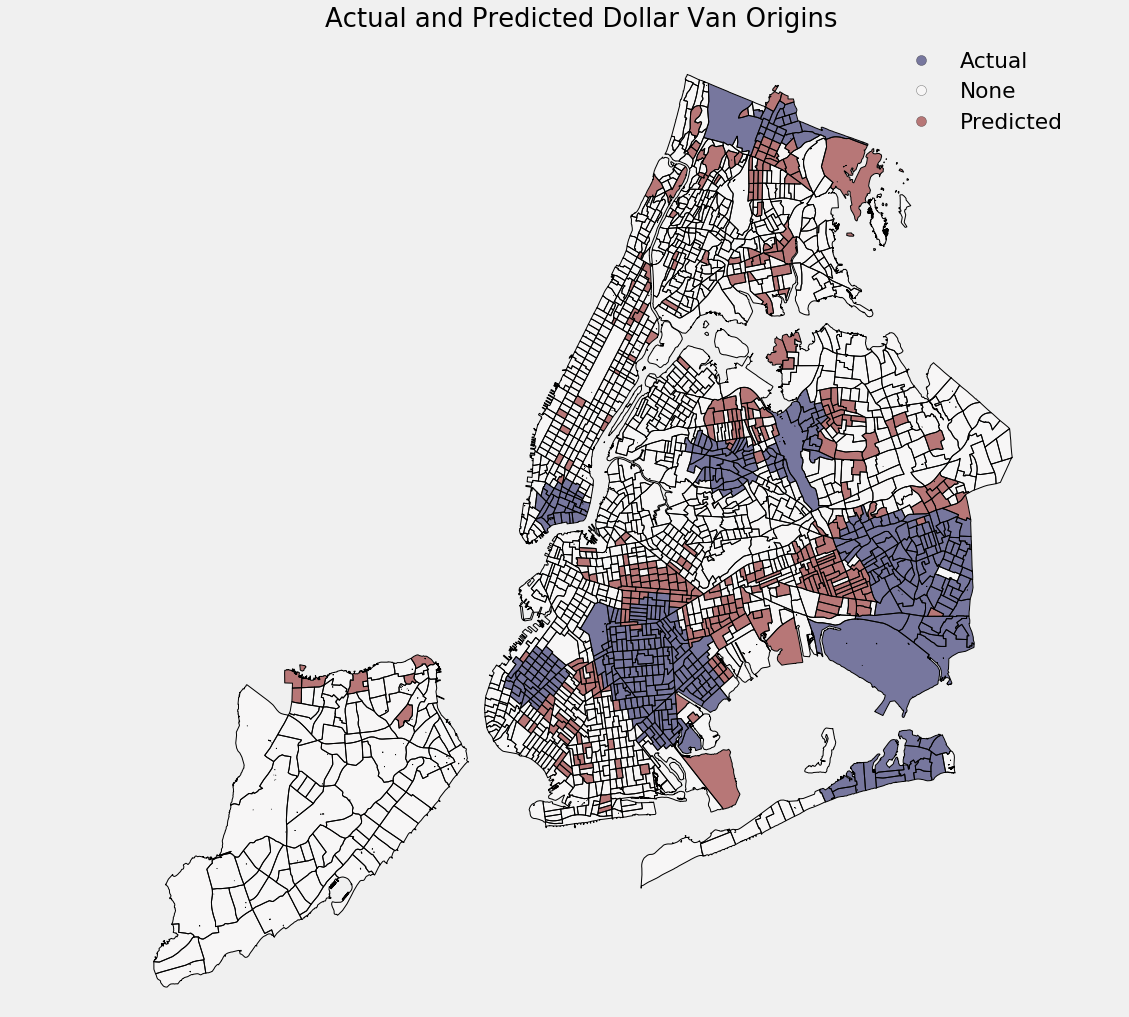

In [48]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp3.plot(axes=ax, column='orig_plot', legend=True, categorical=True, colormap='seismic') #prism, magma, winter
ax.set_title('Actual and Predicted Dollar Van Origins')

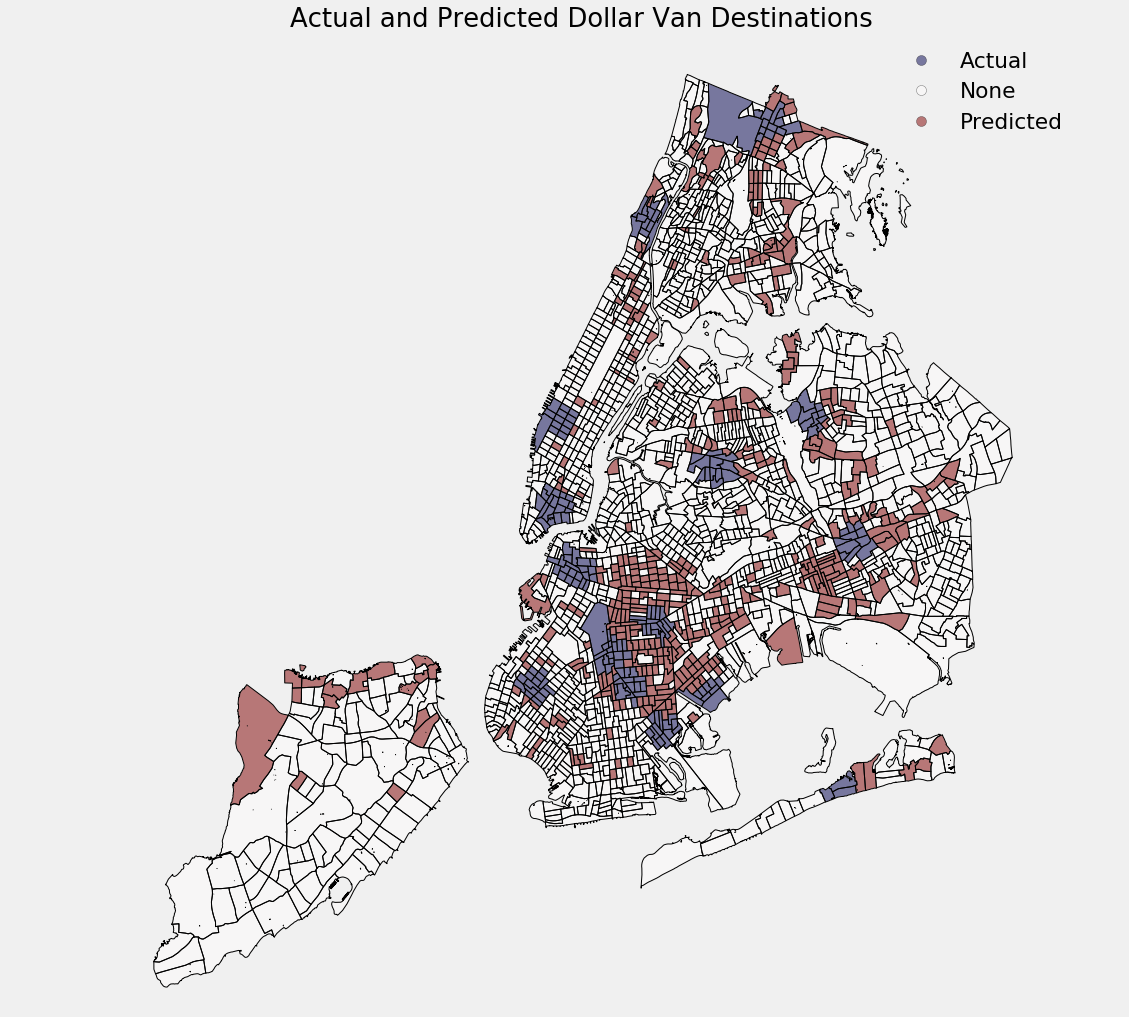

In [50]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp3.plot(axes=ax, column='dest_plot', legend=True, categorical=True, colormap='seismic') #prism, magma, winter
ax.set_title('Actual and Predicted Dollar Van Destinations')

In [54]:
shp3[['tract', 'orig_plot', 'dest_plot']].to_csv('predictions.csv', index=False)

In [90]:
pl.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

In [30]:
shp2 = gp.GeoDataFrame.from_file('../data/merged.json')

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


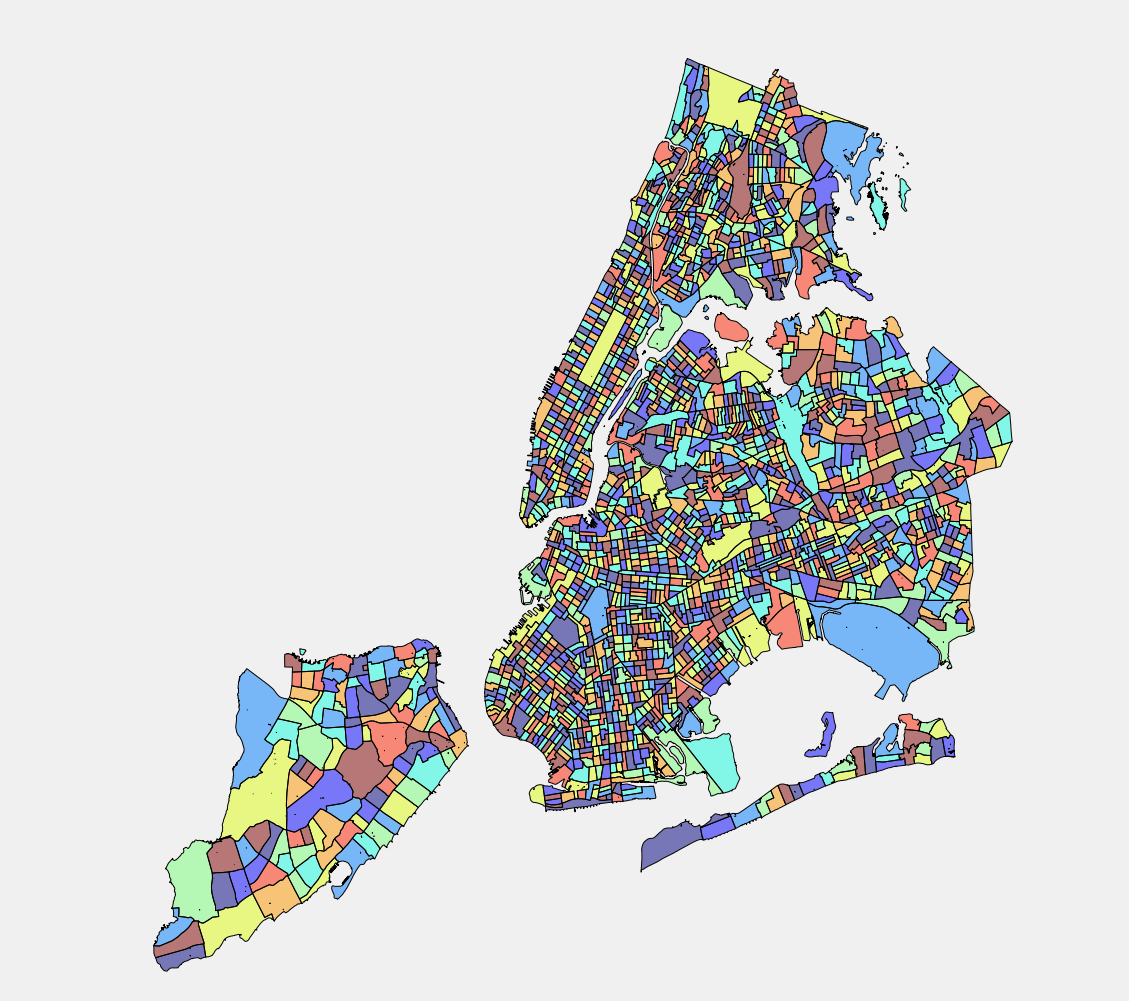

In [26]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp2.plot(axes=ax) #prism, magma

In [44]:
shp3 = shp2[['Origin?', 'Destination?', 'geometry', 'tract']].merge(shp[['tract', 'is_orig_pred', 'is_dest_pred']], how='left', on='tract')

,Origin?,Destination?,geometry,tract,is_orig_pred,is_dest_pred
0,1,0,"POLYGON ((988504.1384277344 198118.3380126953,...",061000201,0,0
1,1,0,"(POLYGON ((989149.298828125 196328.6047973633,...",061000202,1,0
2,1,1,"POLYGON ((987978.8082275391 197698.2456054688,...",061000600,1,1
3,0,0,(POLYGON ((984943.4877929688 194173.7781982422...,061000700,0,0
4,1,1,"POLYGON ((986494.1445922852 197775.8300170898,...",061000800,1,1
5,0,0,(POLYGON ((984175.4826049805 192471.2318115234...,061000900,0,0
6,1,0,"POLYGON ((991128.2537841797 199590.250793457, ...",061001001,1,0
7,1,0,"POLYGON ((990784.524230957 199725.3294067383, ...",061001002,1,0
8,1,0,"POLYGON ((989934.2239990234 199730.8380126953,...",061001200,0,0
9,0,0,"POLYGON ((980015.6190185547 196065.4348144531,...",061001300,0,0


In [38]:
shp2

,Both,Destination?,DollarVanLine,Origin?,average_commute_time,average_walk_distance,geometry,id,number_of_commuters,tract
0,0,0,1,1,573.930196,235.091885,"POLYGON ((988504.1384277344 198118.3380126953,...",0,1934,061000201
1,0,0,1,1,329.486464,94.019527,"(POLYGON ((989149.298828125 196328.6047973633,...",1,4839,061000202
2,1,1,1,1,208.393849,65.878468,"POLYGON ((987978.8082275391 197698.2456054688,...",2,7023,061000600
3,0,0,0,0,106.237555,39.465694,(POLYGON ((984943.4877929688 194173.7781982422...,3,11189,061000700
4,1,1,1,1,209.682176,95.011414,"POLYGON ((986494.1445922852 197775.8300170898,...",4,6104,061000800
5,0,0,0,0,287.232364,121.067453,(POLYGON ((984175.4826049805 192471.2318115234...,5,2991,061000900
6,0,0,1,1,722.709053,293.845071,"POLYGON ((991128.2537841797 199590.250793457, ...",6,1447,061001001
7,0,0,1,1,461.177405,173.921031,"POLYGON ((990784.524230957 199725.3294067383, ...",7,3461,061001002
8,0,0,1,1,382.116454,148.148316,"POLYGON ((989934.2239990234 199730.8380126953,...",8,3057,061001200
9,0,0,0,0,154.604708,53.877743,"POLYGON ((980015.6190185547 196065.4348144531,...",9,6924,061001300


In [40]:
shp

,Both,is_dest,DollarVanLine,is_orig,average_commute_time,average_walk_distance,geometry,id,number_of_commuters,tract,...,rac_total_jobs,rac_jobs_lt_29,rac_jobs_30_54,rac_jobs_gt_55,rac_minc_lt_1250,rac_minc_1251_3333,rac_minc_gt_3333,is_orig_pred,is_dest_pred,orig_plot
0,0,0,1,1,-1.058380,-0.683937,"POLYGON ((988504.1384277344 198118.3380126953,...",0,0.207354,061000201,...,-0.481200,-0.211516,-0.488903,-0.703167,0.024983,-0.362521,-0.567460,0,0,Actual
1,0,0,1,1,-1.471869,-1.405481,"(POLYGON ((989149.298828125 196328.6047973633,...",1,1.683974,061000202,...,1.263153,0.483150,1.324209,1.824599,1.746437,1.143693,0.807462,1,0,Actual
2,1,1,1,1,-1.676703,-1.549415,"POLYGON ((987978.8082275391 197698.2456054688,...",2,2.794107,061000600,...,2.354364,2.118418,2.402168,2.047477,4.249440,2.688627,0.933989,1,1,Actual
3,0,0,0,0,-1.849505,-1.684508,(POLYGON ((984943.4877929688 194173.7781982422...,3,4.911697,061000700,...,3.331247,5.436415,3.119487,0.590614,0.045416,-0.087608,4.987900,0,0,None
4,1,1,1,1,-1.674524,-1.400408,"POLYGON ((986494.1445922852 197775.8300170898,...",4,2.326977,061000800,...,1.835925,1.208018,1.986044,1.846343,4.372036,1.809679,0.503798,1,1,Actual
5,0,0,0,0,-1.543344,-1.267139,(POLYGON ((984175.4826049805 192471.2318115234...,5,0.744630,061000900,...,-0.392907,-0.133851,-0.320472,-0.839068,-0.971110,-1.311164,0.306417,0,0,None
6,0,0,1,1,-0.806713,-0.383431,"POLYGON ((991128.2537841797 199590.250793457, ...",6,-0.040190,061001001,...,-0.868331,-1.065824,-0.792079,-0.654242,-1.119247,-1.284060,-0.365017,1,0,Actual
7,0,0,1,1,-1.249107,-0.996808,"POLYGON ((990784.524230957 199725.3294067383, ...",7,0.983532,061001002,...,0.449272,0.504723,0.468182,0.237271,1.271377,1.279213,-0.307659,1,0,Actual
8,0,0,1,1,-1.382843,-1.128628,"POLYGON ((989934.2239990234 199730.8380126953,...",8,0.778178,061001200,...,-0.012568,-0.310754,0.147172,-0.072584,-0.215101,-0.459321,0.252432,0,0,Actual
9,0,0,0,0,-1.767690,-1.610795,"POLYGON ((980015.6190185547 196065.4348144531,...",9,2.743785,061001300,...,1.482753,2.256488,1.617477,-0.159561,-0.317264,-0.505785,2.534971,0,0,None
